### Part 1.4 Label missing values

In [1]:
%load_ext autoreload
%autoreload 2

In [44]:
import os 
os.environ["RGB_CHANNELS"] = "false"
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from src.config import data_preparation_config as config1, prediction_model_config as config2
from src.utils import *

In [70]:
all_data_save_path = "data/main_data3.pkl"

In [46]:
dic_train_data = load_from_pickle(config1.DIC_NON_MISSING_DATA_PATH)
dic_missing_data = load_from_pickle(config1.DIC_MISSING_DATA_PATH)

In [47]:
features_len = len(dic_train_data)
features_len

14

In [48]:
features = list(dic_train_data.keys())
features

['left_eye_center',
 'right_eye_center',
 'left_eye_inner_corner',
 'left_eye_outer_corner',
 'right_eye_inner_corner',
 'right_eye_outer_corner',
 'left_eyebrow_inner_end',
 'left_eyebrow_outer_end',
 'right_eyebrow_inner_end',
 'right_eyebrow_outer_end',
 'mouth_left_corner',
 'mouth_right_corner',
 'mouth_center_top_lip',
 'mouth_center_bottom_lip']

In [49]:
dic_missing_data["left_eye_center"]

,left_eye_center_x,left_eye_center_y,Image
1687,NaN,NaN,"[[53, 55, 55, 56, 57, 58, 60, 62, 63, 64, 65, ..."
1834,NaN,NaN,"[[68, 68, 69, 68, 68, 70, 67, 68, 73, 70, 70, ..."
1866,NaN,NaN,"[[25, 23, 23, 22, 21, 21, 21, 19, 21, 25, 25, ..."
1938,NaN,NaN,"[[42, 41, 44, 47, 49, 44, 42, 42, 41, 42, 42, ..."
2100,NaN,NaN,"[[35, 16, 26, 31, 56, 33, 18, 25, 39, 71, 96, ..."
2137,NaN,NaN,"[[17, 17, 16, 16, 16, 14, 15, 15, 15, 15, 15, ..."
2153,NaN,NaN,"[[45, 51, 64, 51, 46, 61, 66, 61, 62, 60, 58, ..."
2175,NaN,NaN,"[[0, 0, 1, 0, 0, 1, 0, 1, 2, 2, 2, 2, 2, 2, 4,..."
2186,NaN,NaN,"[[178, 176, 174, 168, 159, 154, 150, 144, 135,..."
2239,NaN,NaN,"[[5, 7, 7, 12, 24, 53, 87, 81, 67, 87, 113, 12..."


### Predict the missing values

In [59]:
# predict features corrdinates using the trained models for the 14 features that contain missing values
# for each feature load its dataframe of which has the images that we shall predict the missing corrdinates for.
# preprocess the images first inorder to be able to feed it to the trained model, predict the coordinates for each image, then in case the coordinates were normalized in the 
# previous part then we need to reverse normalizing them using its corresponding scalers. And finaly fill the missing values with the predicted values
for i in range(0, len(features[:])):
    feature_name = features[i]
    df = dic_missing_data[feature_name]
    imgs = pre_process_images(df, config2.RGB_CHANNELS, config2.NORMALIZE_COORDINATES)
    model = load_model('models/v2/'+feature_name+'/model', compile=False)
    preds = model.predict(imgs)
    scaler = pkl.load(open("scalers/v2/"+feature_name+"_scaler.pkl","rb"))
    if config2.NORMALIZE_COORDINATES:
        preds = scaler.inverse_transform(preds)    
    dic_missing_data[feature_name].iloc[:,:-1] = preds


/home/maria/anaconda3/envs/FacialKeypointsDetection/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/maria/anaconda3/envs/FacialKeypointsDetection/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/maria/anaconda3/envs/FacialKeypointsDetection/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/maria/anaconda3/envs/FacialKeypointsDetection/lib/python3.6/site-packages/sklearn/base.py:334: Us

In [60]:
save_to_pickle(dic_missing_data,"dic_missing_data_filled.pkl")

In [61]:
df = dic_missing_data["left_eye_center"]

In [62]:
df.head()

,left_eye_center_x,left_eye_center_y,Image
1687,67.170395,41.056522,"[[53, 55, 55, 56, 57, 58, 60, 62, 63, 64, 65, ..."
1834,52.727856,35.219856,"[[68, 68, 69, 68, 68, 70, 67, 68, 73, 70, 70, ..."
1866,62.310017,36.798344,"[[25, 23, 23, 22, 21, 21, 21, 19, 21, 25, 25, ..."
1938,66.251762,41.277626,"[[42, 41, 44, 47, 49, 44, 42, 42, 41, 42, 42, ..."
2100,62.311451,40.636734,"[[35, 16, 26, 31, 56, 33, 18, 25, 39, 71, 96, ..."


In [63]:
#  load nose_tip features
nose_tip = load_from_pickle(config1.NOSE_TIP_DATA_PATH)

In [64]:
nose_tip

,index,nose_tip_x,nose_tip_y,Image
0,0,44.420571,57.066803,"[[238, 236, 237, 238, 240, 240, 239, 241, 241,..."
1,1,48.206298,55.660936,"[[219, 215, 204, 196, 204, 211, 212, 200, 180,..."
2,2,47.557263,53.538947,"[[144, 142, 159, 180, 188, 188, 184, 180, 167,..."
3,3,51.885078,54.166539,"[[193, 192, 193, 194, 194, 194, 193, 192, 168,..."
4,4,43.299534,64.889521,"[[147, 148, 160, 196, 215, 214, 216, 217, 219,..."
...,...,...,...,...
7044,7044,48.265961,67.029093,"[[71, 74, 85, 105, 116, 128, 139, 150, 170, 18..."
7045,7045,47.910346,66.626011,"[[60, 60, 62, 57, 55, 51, 49, 48, 50, 53, 56, ..."
7046,7046,49.462572,67.515161,"[[74, 74, 74, 78, 79, 79, 79, 81, 77, 78, 80, ..."
7047,7047,50.754202,66.724988,"[[254, 254, 254, 254, 254, 238, 193, 145, 121,..."


### Merge the complete and filled data 

In [65]:
all_data_dic = dict()
for i in range (0, len(features[:])):
    feature_name = features[i]
    d1 = dic_train_data[feature_name]
    d2 = dic_missing_data[feature_name]
    d_new = pd.concat([d1,d2], ignore_index=False)
    d_new.rename(columns={'Image': 'Image_'+feature_name},inplace=True)
    all_data_dic[feature_name] = d_new.reset_index()

In [66]:
all_dataframes= list(all_data_dic.values())

### Add the nose_tip feature to the data

In [67]:
all_dataframes.append(nose_tip)

In [68]:
all_dataframes[-1].head()

,index,nose_tip_x,nose_tip_y,Image
0,0,44.420571,57.066803,"[[238, 236, 237, 238, 240, 240, 239, 241, 241,..."
1,1,48.206298,55.660936,"[[219, 215, 204, 196, 204, 211, 212, 200, 180,..."
2,2,47.557263,53.538947,"[[144, 142, 159, 180, 188, 188, 184, 180, 167,..."
3,3,51.885078,54.166539,"[[193, 192, 193, 194, 194, 194, 193, 192, 168,..."
4,4,43.299534,64.889521,"[[147, 148, 160, 196, 215, 214, 216, 217, 219,..."


### Merge all the features together into main dataframe

In [69]:
main_df = reduce(lambda  left,right: pd.merge(left,right,on=['index'],how='inner'), all_dataframes)

In [71]:
main_df.columns

Index(['index', 'left_eye_center_x', 'left_eye_center_y',
       'Image_left_eye_center', 'right_eye_center_x', 'right_eye_center_y',
       'Image_right_eye_center', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'Image_left_eye_inner_corner',
       'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
       'Image_left_eye_outer_corner', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'Image_right_eye_inner_corner',
       'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
       'Image_right_eye_outer_corner', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'Image_left_eyebrow_inner_end',
       'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
       'Image_left_eyebrow_outer_end', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'Image_right_eyebrow_inner_end',
       'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
       'Image_right_eyebrow_outer_end', 'mouth_left_corner_x',
       'mouth_left_cor

### Leave only one column for the image

In [72]:
main_df.columns = [*main_df.columns[:-1], 'Image']
main_df = main_df.loc[:, ~main_df.columns.str.startswith('Image_')]
main_df.drop(columns=["index"], inplace=True)

In [73]:
main_df.head(1)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,nose_tip_x,nose_tip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,44.420571,57.066803,"[[238, 236, 237, 238, 240, 240, 239, 241, 241,..."


### Visualize random images

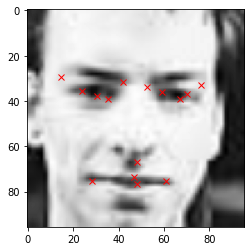

In [75]:
visualize_random_indexed_image(main_df)

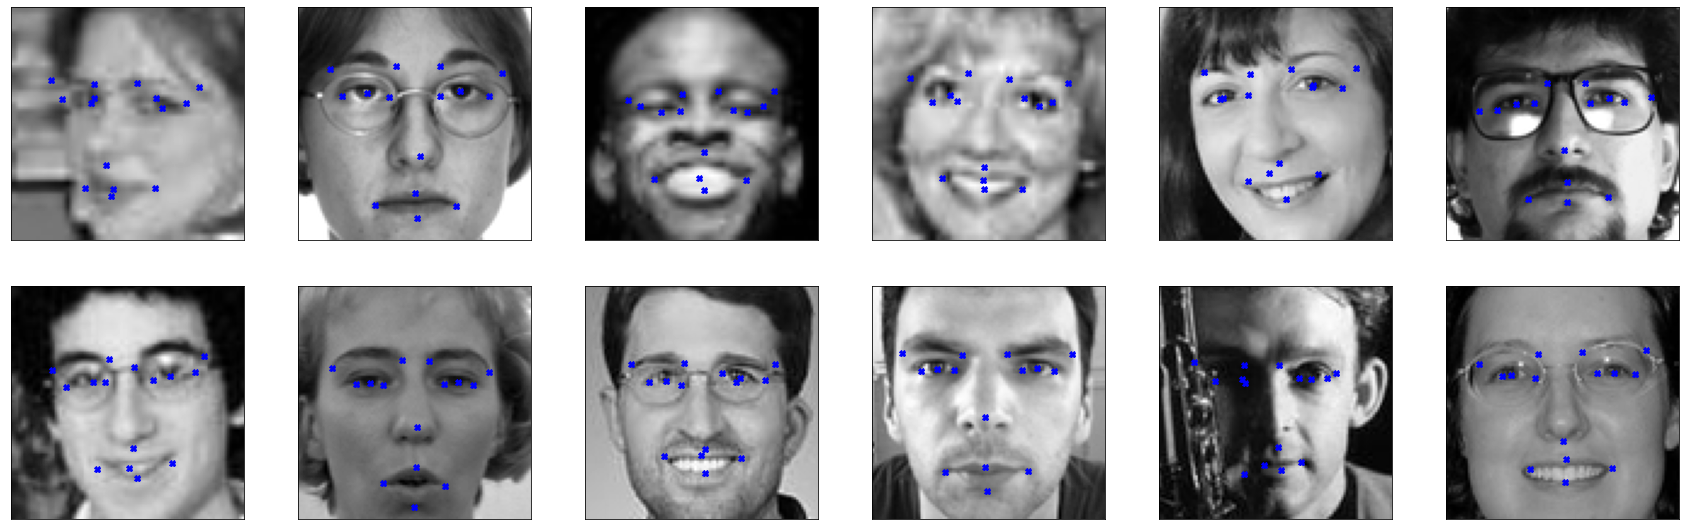

In [90]:
visualize_random_indexed_images(main_df, "images/filled_image.png")

### Save the main data to use it in the next part (building the prediction model)

In [84]:
save_to_pickle(main_df, all_data_save_path)

## Ready to Train!

Now that we've prepared our data, we're ready to build a neural network to train on this data.

In the next notebook, we'll be tasked with creating a prediction model for facial keypoint detection.